In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

In [37]:
diabetes = pd.read_csv('diabetes.csv', delimiter = ',',encoding = 'utf-8', header = 0)

In [38]:
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [39]:
diabetes = diabetes[diabetes['smoking_history'] != 'No Info']

In [40]:
# Create dummy variables for the 'Smoking' column
smoking_dummies = pd.get_dummies(diabetes['smoking_history'], prefix='smoking')

# Merge the dummy variables with the original DataFrame
diabetes = pd.concat([diabetes, smoking_dummies], axis=1)

# Drop the original 'Smoking' column, as it is no longer needed
diabetes = diabetes.drop('smoking_history', axis=1)

In [41]:
diabetes = diabetes[diabetes['age'] > 3.0]

In [42]:
diabetes['gender'] = diabetes['gender'].replace({'Male': 0, 'Female': 1})

In [43]:
diabetes = diabetes[diabetes['gender'] != 'Other']

In [44]:
diabetes.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
0,1,80.0,0,1,25.19,6.6,140,0,0,0,0,1,0
2,0,28.0,0,0,27.32,5.7,158,0,0,0,0,1,0
3,1,36.0,0,0,23.45,5.0,155,0,1,0,0,0,0
4,0,76.0,1,1,20.14,4.8,155,0,1,0,0,0,0
5,1,20.0,0,0,27.32,6.6,85,0,0,0,0,1,0


In [45]:
unique_values = diabetes['gender'].unique()
print(unique_values)

[1 0]


In [46]:
other_count = len(diabetes[diabetes['gender'] == 'Other'])
print("other_count:", other_count)

other_count: 0


In [47]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63699 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               63699 non-null  object 
 1   age                  63699 non-null  float64
 2   hypertension         63699 non-null  int64  
 3   heart_disease        63699 non-null  int64  
 4   bmi                  63699 non-null  float64
 5   HbA1c_level          63699 non-null  float64
 6   blood_glucose_level  63699 non-null  int64  
 7   diabetes             63699 non-null  int64  
 8   smoking_current      63699 non-null  uint8  
 9   smoking_ever         63699 non-null  uint8  
 10  smoking_former       63699 non-null  uint8  
 11  smoking_never        63699 non-null  uint8  
 12  smoking_not current  63699 non-null  uint8  
dtypes: float64(3), int64(4), object(1), uint8(5)
memory usage: 4.7+ MB


In [48]:
X = diabetes[['gender','age','hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_current', 'smoking_ever', 'smoking_former', 'smoking_never', 'smoking_not current']].values
y = diabetes['diabetes'].values

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [53]:
print(np.bincount(y_resampled))

[45074 45074]


In [60]:
# create a standard scaler object and fit it to the training data
scaler = StandardScaler()
scaler.fit(X_resampled)

# transform the training and test data using the scaler
X_train_std = scaler.transform(X_resampled)
X_test_std = scaler.transform(X_test)

In [61]:
model_RF_Class = RandomForestClassifier(n_estimators = 100, max_depth = 15)


In [62]:
model_RF_Class.fit(X_resampled,y_resampled)

RandomForestClassifier(max_depth=15)

In [63]:
model_RF_Class.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
# measure the accuracy and print it
accuracy_train = round(model_RF_Class.score(X_resampled,y_resampled),4)
accuracy_test = round(model_RF_Class.score(X_test,y_test),4)

print("The model's accuracy for the train data is: \t", accuracy_train)
print("The model's accuracy for the test data is: \t", accuracy_test)

The model's accuracy for the train data is: 	 0.9765
The model's accuracy for the test data is: 	 0.9615


In [65]:
# Confusion Matrix

prediction = model_RF_Class.predict(X_resampled)

cf_matrix= confusion_matrix(y_resampled, prediction)

<AxesSubplot:>

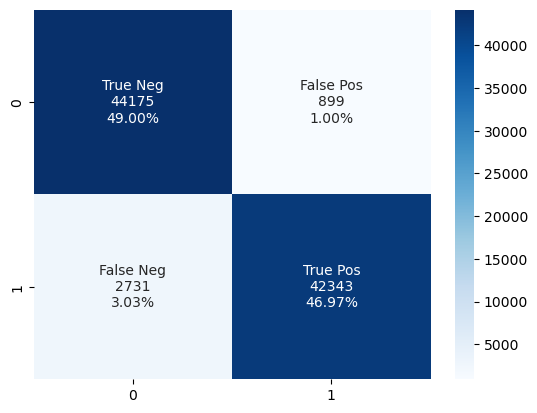

In [27]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [28]:
prediction_test = model_RF_Class.predict(X_test)

cf_matrix_test = confusion_matrix(y_test, prediction_test)

<AxesSubplot:>

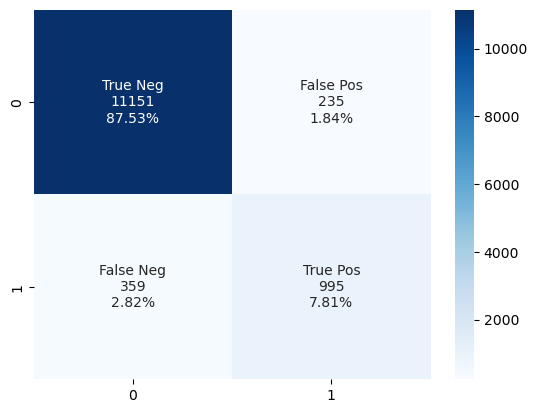

In [32]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_test.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test, annot=labels, fmt="", cmap='Blues')

In [33]:
import matplotlib.pyplot as plt
from sklearn import tree


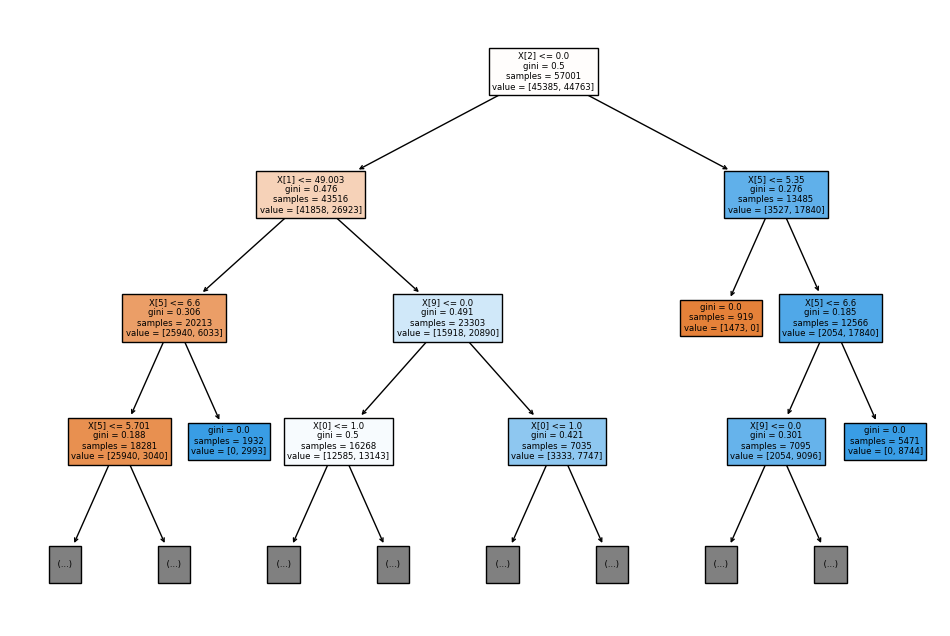

In [34]:
first_tree = model_RF_Class.estimators_[0]

plt.figure(figsize=(12,8))
tree.plot_tree(first_tree, filled=True, max_depth=3)
plt.show()